# Plate Number Detector

In this notebook we will make plate number detector. Using YOLO v4 and Darknet Framework.

Please follow each step correctly.

# Step 1 : Preparing

## Cloning darknet repo and active gpu.

We will use darknet repo and use GPU to train our models. If please make sure active your GPU because it will takes a lot of time to train our model.

In [ ]:
# clone darknet framework 
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14997, done.
remote: Total 14997 (delta 0), reused 0 (delta 0), pack-reused 14997
Receiving objects: 100% (14997/14997), 13.38 MiB | 21.05 MiB/s, done.
Resolving deltas: 100% (10194/10194), done.


In [ ]:
# clone toolkit to labeling data
!git clone https://github.com/theAIGuysCode/OIDv4_ToolKit.git

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 444, done.
remote: Total 444 (delta 0), reused 0 (delta 0), pack-reused 444
Receiving objects: 100% (444/444), 34.09 MiB | 32.78 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make --quiet 

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

## Setup google drive entry.

We will use google drive later, so for now let's make google drive entry so we can copy folder from google drive to our Colab's file.


In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


# Step 2: Gathering and Labeling a Custom Dataset

In this step, we will use OID v4 to gather data from Open Image Dataset.

We need to install package requirements before run our tool.

In [ ]:
%cd /content/OIDv4_ToolKit

/content/OIDv4_ToolKit


In [ ]:
!pip3 install -r requirements.txt

### Training Dataset
If you want to use another dataset you can run command below. I chose to use 1500 images within my dataset but the general rule is the more images the better for higher accuracy of your model. 
```
python main.py downloader --classes 'Vehicle registration plate' --type_csv train --limit 1500
```

This creates a folder with 1500 images of 'Vehicle registration plates' (license plates) for us to train our custom object detector with.

```But since I use my own dataset, I just need to copy my dataset to train.```


In [ ]:
!cp /content/gdrive/MyDrive/PlateDetector/OID.zip /content/OIDv4_ToolKit

In [ ]:
!unzip OID.zip

## Converting Labels to YOLOv4 Format
The labels that we get from the toolkit are not in the proper YOLOv4 format. Luckily, with a few simple commands we can convert them to the proper format.

Within the root OIDv4_ToolKit folder open the file classes.txt and edit it to have the classes you just downloaded, one per line.

```
change all to : Vehicle Registration Plate
```

Now run this command to convert the labels generated by OIDv4_Toolkit into YOLOv4 labels (this should convert both train and validation dataset labels):

```
python convert_annotations.py
```

This converts all labels to YOLOv4 format which can now be used by darknet to properly train our custom object detector.


In [ ]:
# convert image with annotations.
!python convert_annotations.py

Currently in subdirectory: validation
Converting annotations for class:  Vehicle registration plate
100% 386/386 [00:06<00:00, 58.08it/s]
Currently in subdirectory: train
Converting annotations for class:  Vehicle registration plate
100% 2823/2823 [00:50<00:00, 55.66it/s]


Remove the old 'Label' folder in the train and validation folders which contains the non YOLOv4 formatted labels by running the following: (your file path will have a different name for 'Vehicle registration plate'... depending on which classes you downloaded.
```
rm -r OID/Dataset/train/'Vehicle registration plate'/Label/
```
And finally delete the old labels for validation as well.
```
rm -r OID/Dataset/validation/'Vehicle registration plate'/Label/
```
If this command doesn't work on your machine then just go to the folder with 'Label' and right click and hit Delete to manually delete it.



In [ ]:
!rm -r OID/Dataset/train/'Vehicle registration plate'/Label/
!rm -r OID/Dataset/validation/'Vehicle registration plate'/Label/

In [ ]:
# unzip the datasets and their contents so that they are now in /darknet/data/ folder
!mv /content/OIDv4_ToolKit/OID/Dataset/validation /content/darknet/data
!mv /content/OIDv4_ToolKit/OID/Dataset/train /content/darknet/data
%cd /content/darknet

/content/darknet


In [ ]:
!mv "/content/darknet/data/train/Vehicle registration plate" "/content/darknet/data/train/obj"
!mv "/content/darknet/data/train/obj" "/content/darknet/data/obj"

# # move test to new folder name

!mv "/content/darknet/data/validation/Vehicle registration plate" "/content/darknet/data/train/test"
!mv "/content/darknet/data/train/test" "/content/darknet/data/test"

In [ ]:
!rm -r /content/darknet/data/train
!rm -r /content/darknet/data/validation

# Step 3: Configuring Files for Training
This step involves properly configuring custom .cfg, obj.data, obj.names, train.txt and test.txt files.

## 1. Configure .cfg file

I use my own config file here, so I just need to copy from my google drive config to ./cfg (darknet folder)


In [ ]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/PlateDetector/yolov4-plate-detector.cfg ./cfg

## 2. Make obj names and obj data

I use my own files here, already configured to detect 'license_plate' as class. Also setup my backup folder to save .weights model later.

In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/PlateDetector/obj.names ./data
!cp /content/gdrive/MyDrive/PlateDetector/obj.data ./data

## 3. Generating train.txt and test.txt
The last configuration files needed before we can begin to train our custom detector are the train.txt and test.txt files which hold the relative paths to all our training images and valdidation images.

Just download the two files to your local machine and upload them to Google Drive so we can use them in the Colab Notebook.

In [ ]:
# upload the generate_train.py and generate_test.py script to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/PlateDetector/generate_test.py ./
!cp /content/gdrive/MyDrive/PlateDetector/generate_train.py ./

Now simply run both scripts to do the work for you of generating the two txt files.

In [ ]:
!python /content/darknet/generate_test.py
!python /content/darknet/generate_train.py

# Step 4: Download pre-trained weights for the convolutional layers.
This step downloads the weights for the convolutional layers of the YOLOv4 network. By using these weights it helps your custom object detector to be way more accurate and not have to train as long. 

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
!wget http://pjreddie.com/media/files/darknet53.conv.74

--2021-05-11 14:18:38--  http://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/darknet53.conv.74 [following]
--2021-05-11 14:18:38--  https://pjreddie.com/media/files/darknet53.conv.74
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  40.7MB/s    in 3.8s    

2021-05-11 14:18:41 (40.7 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



# Step 5: Train Your Custom Object Detector!
You are now ready to train your custom YOLOv4 object detector on whatever crazy classes you have decided on. So run the following command. (-dont_show flag stops chart from popping up since Colab Notebook can't open images on the spot, -map flag overlays mean average precision on chart to see how accuracy of your model is, only add map flag if you have a validation dataset)
```
!./darknet detector train <path to obj.data> <path to custom config> yolov4.conv.137 -dont_show -map
```
**TIP:** This training could take several hours depending on how many iterations you chose in the .cfg file. 

In [ ]:
# train your custom detector! (uncomment %%capture below if you run into memory issues or your Colab is crashing)
# %%capture
!./darknet detector train data/obj.data cfg/yolov4-plate-detector.cfg yolov4.conv.137 -dont_show -map

After training, you can observe a chart of how your model did throughout the training process by running the below command. It shows a chart of your average loss vs. iterations. For your model to be 'accurate' you should aim for a loss under 2.

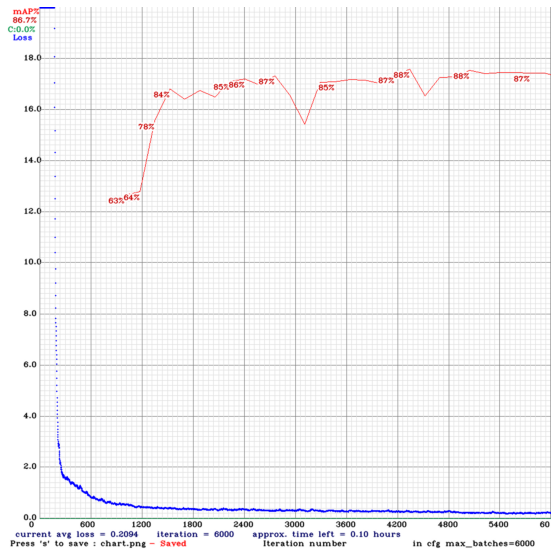

In [ ]:
imShow('chart.png')

# Step 6: Checking the Mean Average Precision (mAP) of Your Model
If you didn't run the training with the '-map- flag added then you can still find out the mAP of your model after training. 

Run the following command on any of the saved weights from the training to see the mAP value for that specific weight's file. 

**NOTE:** ```If you think your final weights file has overfitted then it is important to run these mAP commands to see if one of the previously saved weights is a more accurate model for your classes.```

In [ ]:
!./darknet detector map data/obj.data cfg/yolov4-plate-detector.cfg /content/gdrive/MyDrive/Yolo/backup/yolov4-plate-detector_final.weights

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF

# Step 7: Run Model

Now it's done! You can input your own images to try to detect if your model working correctly.

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov4-plate-detector.cfg /content/gdrive/MyDrive/Yolo/backup/yolov4-plate-detector_final.weights /content/mobil.jpg
imShow('predictions.jpg')

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-plate-detector.cfg /content/gdrive/MyDrive/Yolo/backup/yolov4-plate-detector_final.weights /content/mobil3.jpg
imShow('predictions.jpg')

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 10

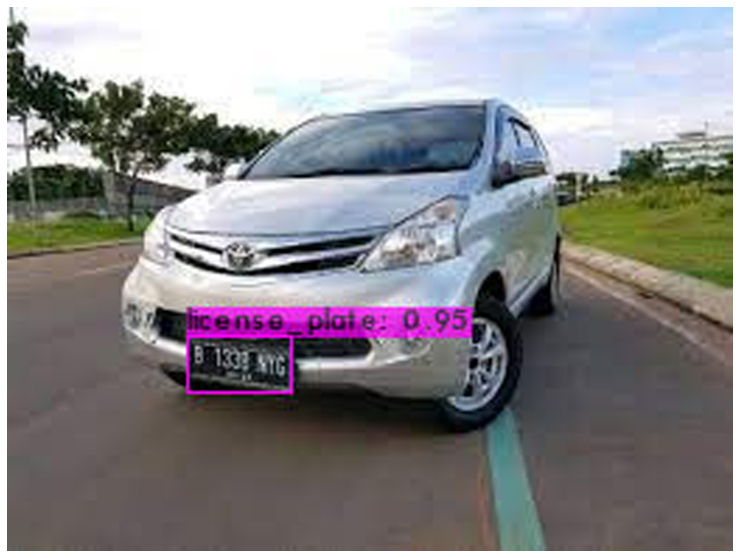

In [ ]:
!./darknet detector test data/obj.data cfg/yolov3.cfg /content/gdrive/MyDrive/PlateDetector/FinalResult/yolov3_best.weights /content/avanza.jpg
imShow('predictions.jpg')

In [ ]:
!cp /content/darknet/results.avi /content/gdrive/MyDrive/Yolo/